# Libraries

In [1]:
import os, json
import pandas as pd
from lib import modelling_mf
import numpy as np
import pickle

# Set up

In [2]:
algorithm = 'DMF'
batch_size = 1024

user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

# Process

## A. Fairbook

In [3]:
# These change for every dataser
data = 'fairbook'
ratings = pd.read_csv("data/"+data+"/"+data+"_events.csv")
all_items=set(ratings.item.unique())

In [4]:
final_recs_files = {}
for fold in range(1,6):


    # Set locations of recommendations and best iteration files
    recs_location = 'results/'+data+str(fold)+'/recs/'
    best_iter_location = 'results/'+data+str(fold)+'/performance/'
    
    # Find all json files in the folder (they contain the best iterations).
    bestmodelparams_files = [best_iter_location + pos_json for pos_json in os.listdir(best_iter_location) if pos_json.endswith('.json')]

    # For every json find the mlp value and the equivalent best iteration and learning rate (which was set after hyperparameter tuning).
    best_iters = {}
    for file in bestmodelparams_files:
        with open(file) as f:
            d = json.load(f)
        mlp = d[1]['configuration']['item_mlp']
        best_iteration = d[1]['configuration']['best_iteration']
        lr = d[1]['configuration']['lr'] # this was found in a previous step, not during training
        best_iters[mlp] = (lr, best_iteration)
        
    # For every mlp value, find the file that contains the recommendations.
    mlp_values = best_iters.keys()
    
    for mlp in mlp_values:
        lr = str(best_iters[mlp][0]).replace('.','$')
        bi = str(best_iters[mlp][1])
        mlp = mlp.replace(',','-').replace('(','').replace(')','')
        recs_file = recs_location + algorithm+'_seed=42_e=25_bs='+str(batch_size)+'_lr='+lr+'_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it='+bi+'.tsv'
        final_recs_files[fold,mlp] = recs_file
    mlp_values = np.unique([x[1] for x in final_recs_files.keys()]) # change the format   

64-32


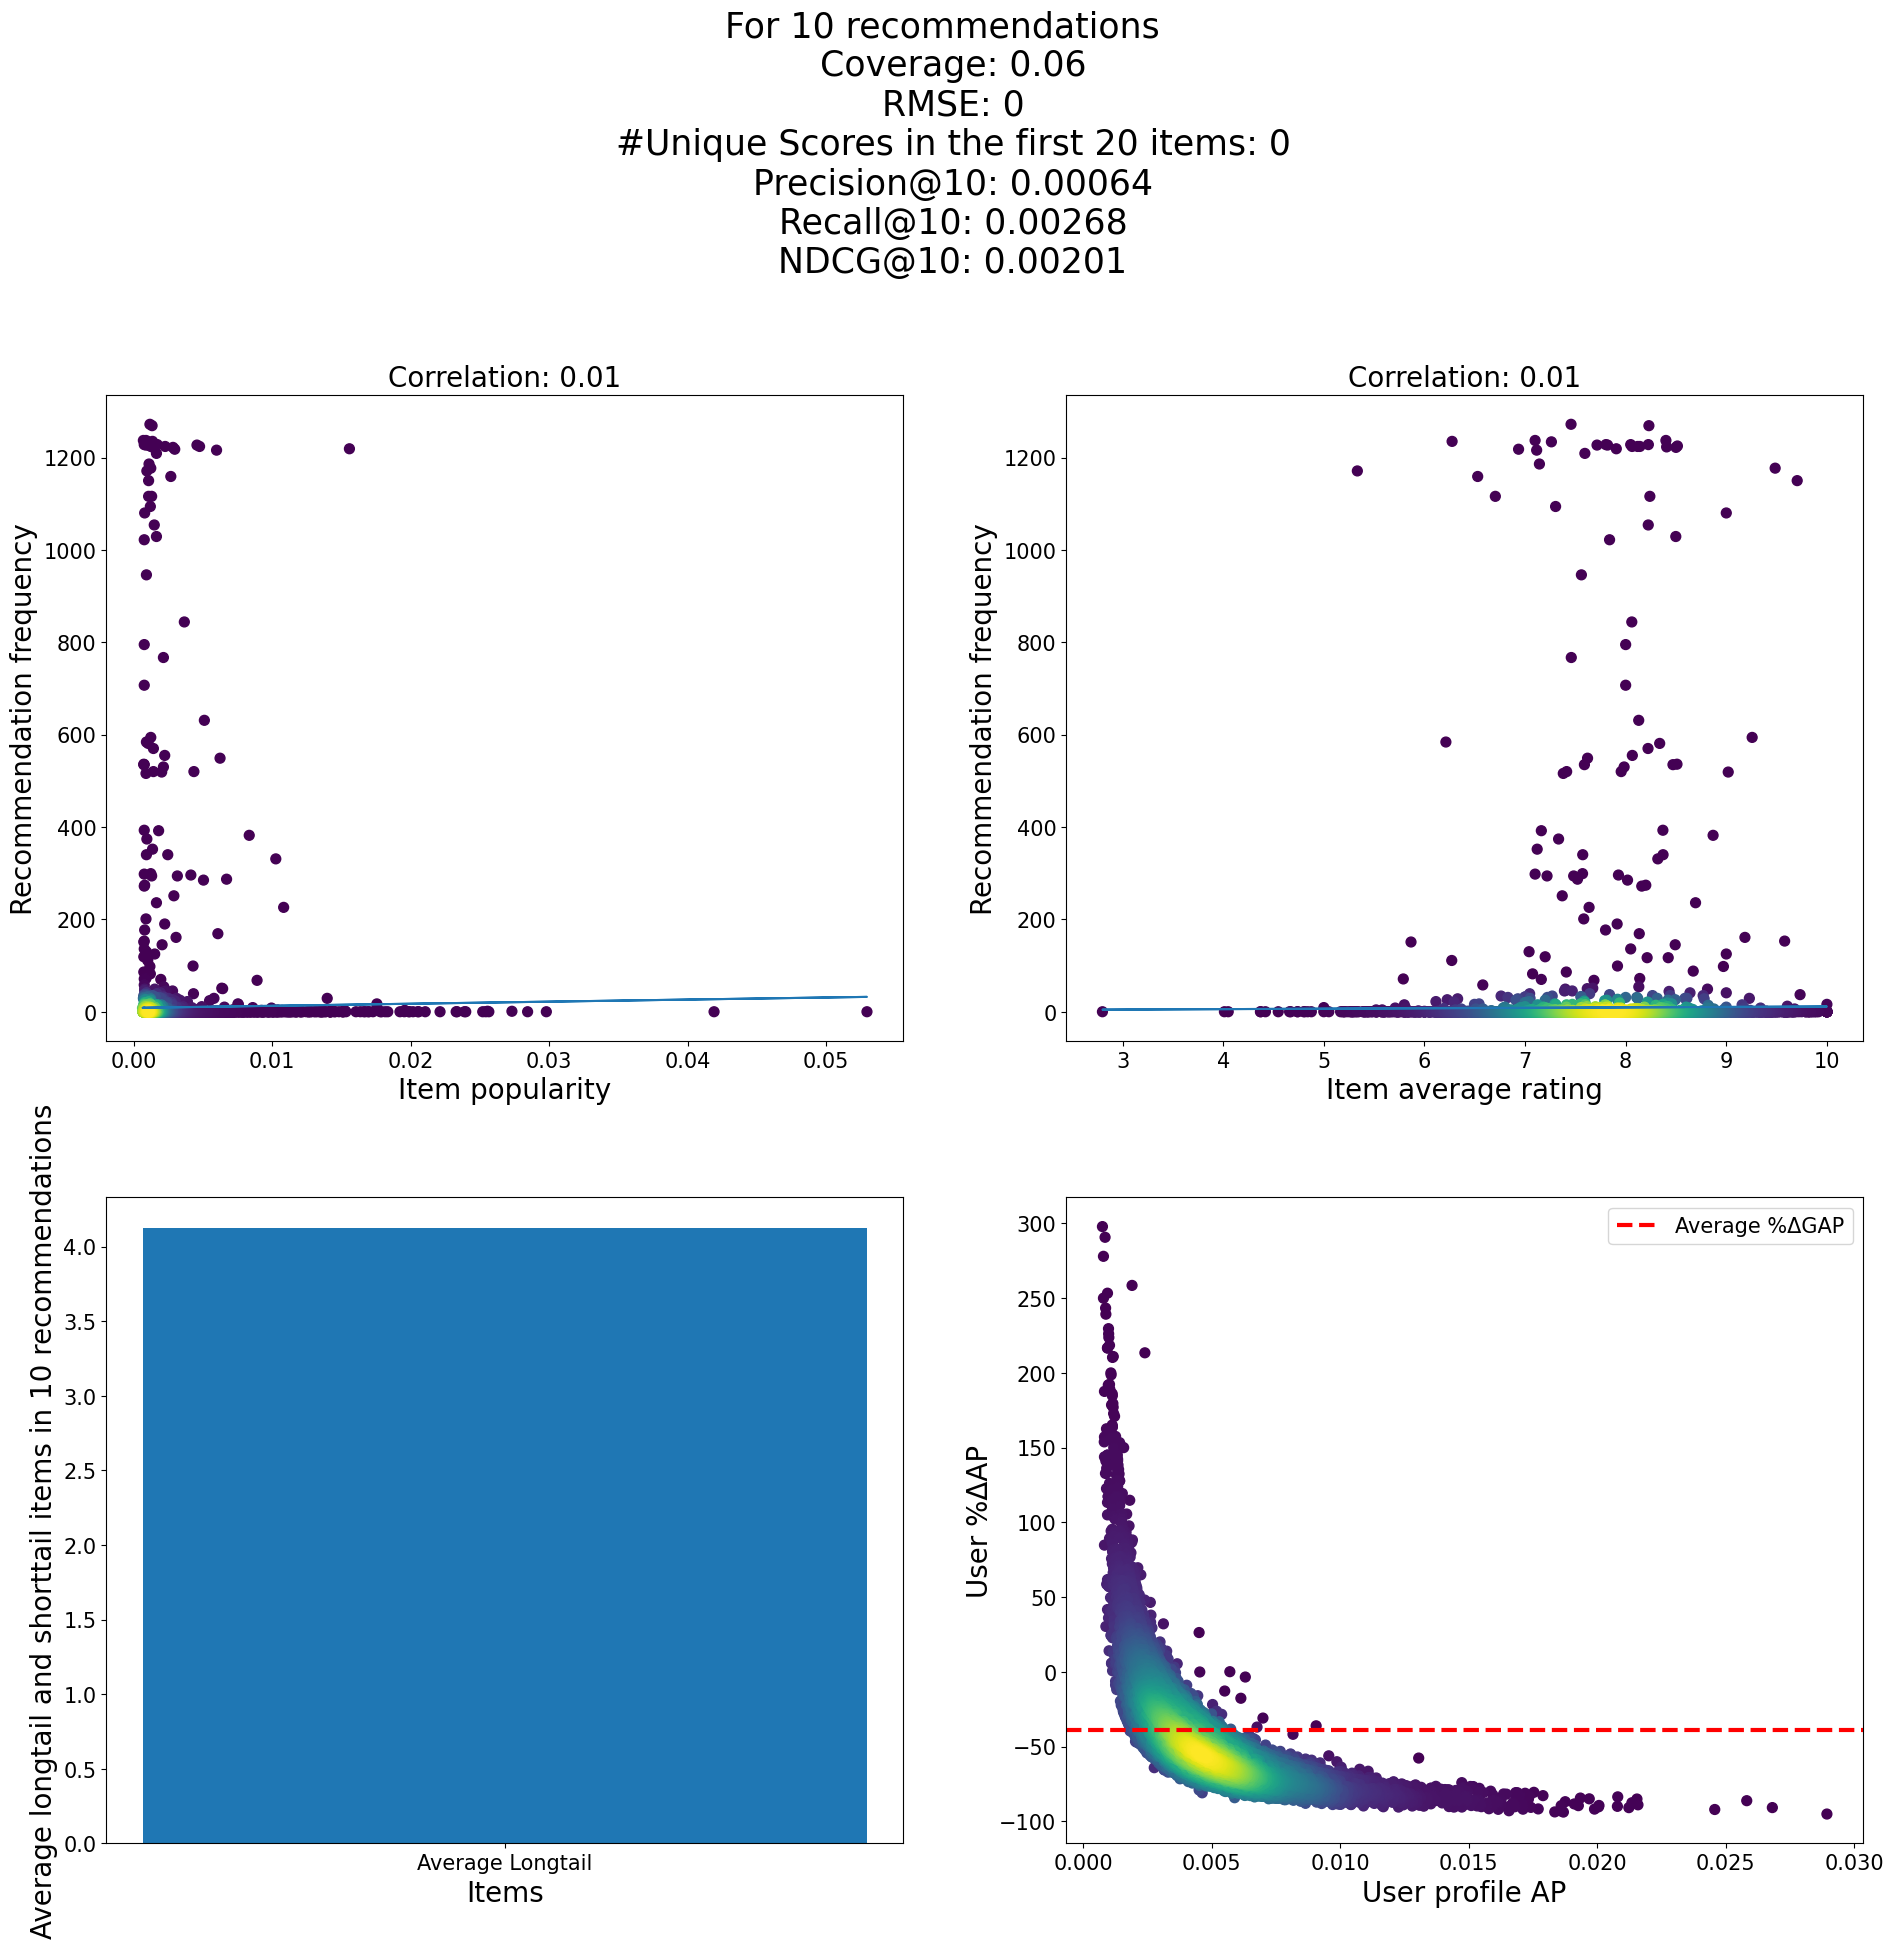

64-64


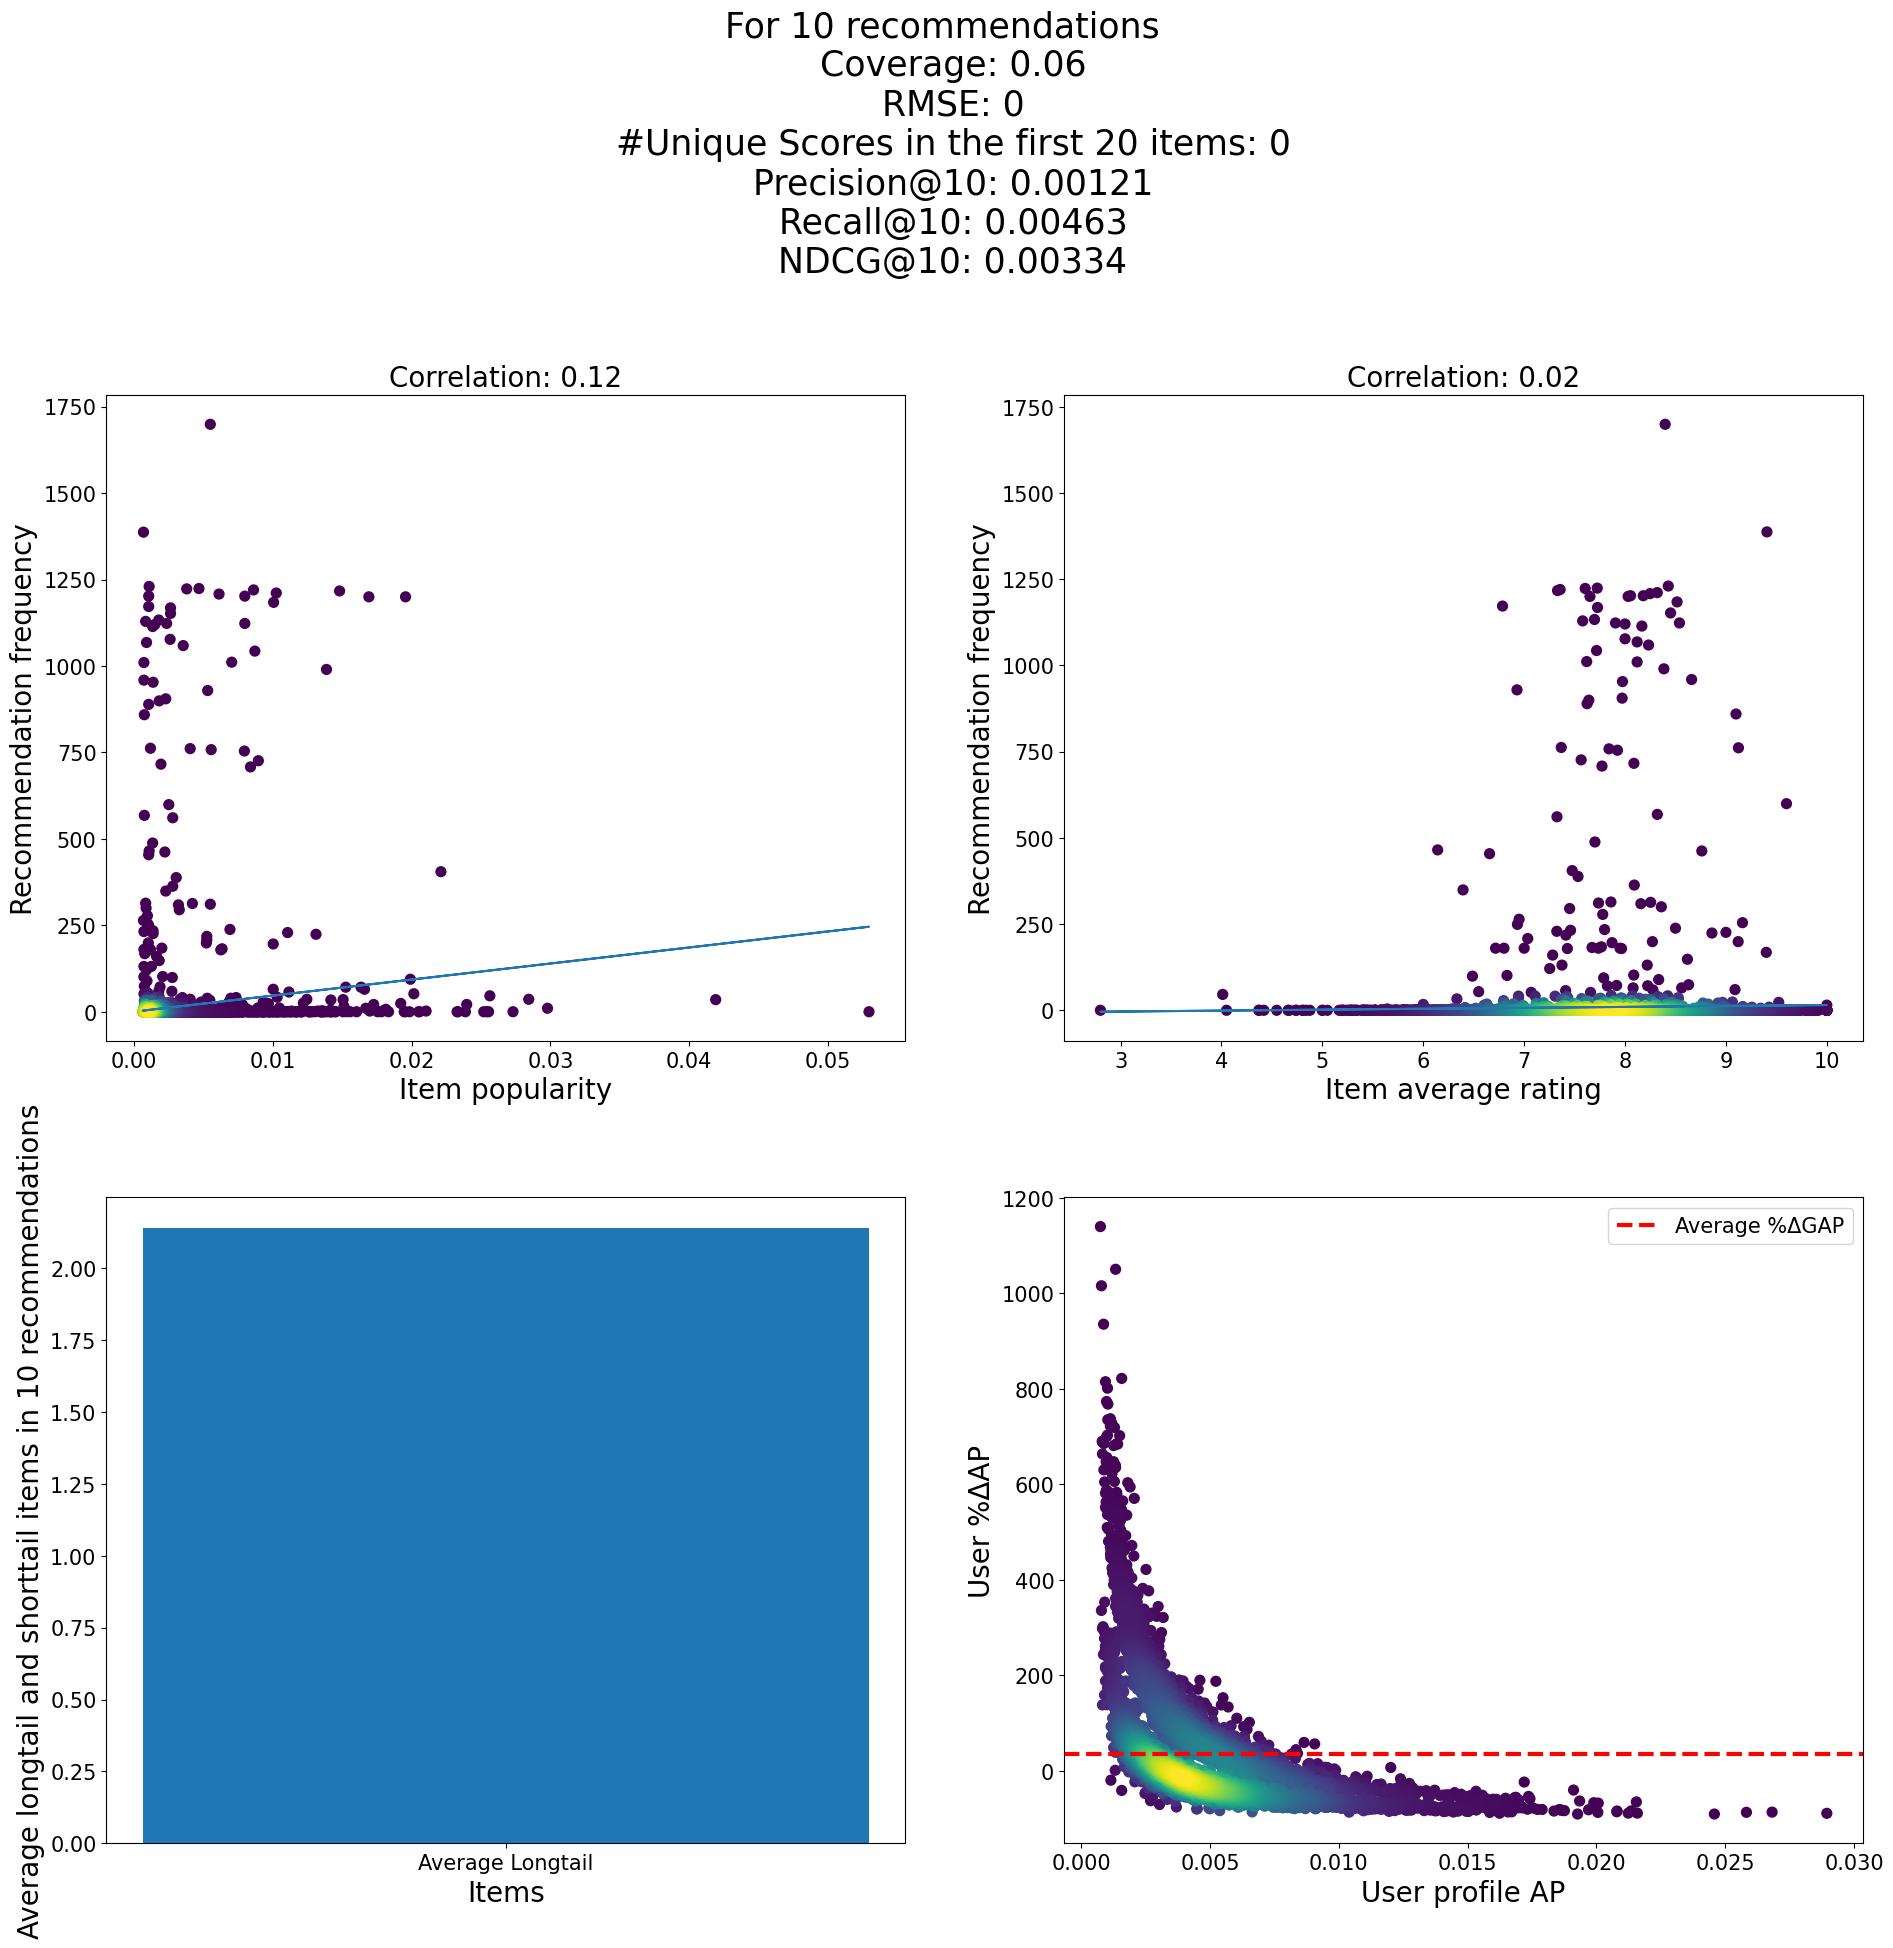

In [5]:
for mlp in mlp_values:
    print(mlp)
    metrics = []
    
    total_ndcg = 0.0
    total_st_dev_20 = 0.0
    total_pop_bias_10 = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_ACLT = 0.0
    # total_ACST = 0.0
    total_GAP_vs_GAP = []
    total_ARP = 0.0
    total_ave_PL = 0.0

    for fold in range(1,6):
        # Train and test files of that fold
        train_file = 'data/'+data+'_fold_'+str(fold)+'_train.csv'
        test_file = 'data/'+data+'_fold_'+str(fold)+'_test.csv'
    
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        test_users = test_df.user.unique()

        # Recommendations
        recs_file = final_recs_files[fold,mlp]
        recs_df = pd.read_csv(recs_file, sep='\t', header=None)
        recs_df.columns = ['user','item','rating']

        # Test recommendations
        test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
        test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)

        # Calculate all metrics
        pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs) # OK
        GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped) # OK
        #pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
        precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df) # OK
        # AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
        ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs) # OK
        
        total_ACLT += ACLT
        total_ARP += ARP
        total_ave_PL += ave_PL
        total_GAP_vs_GAP.append(GAP_vs_GAP)
        total_pop_bias_10 += pop_bias
        total_precision += precision
        total_recall += recall
        total_ndcg += ndcg

    total_precision /= 5.0
    total_recall /= 5.0
    total_ndcg /= 5.0
    total_ACLT /= 5.0
    total_ARP /= 5.0
    total_ave_PL /= 5.0

    total_GAP_vs_GAP = pd.concat(total_GAP_vs_GAP)
    pop_biases = [total_pop_bias_10]
    AggDiv = modelling_mf.evaluate_item_coverage(total_pop_bias_10["recommendation"].values)
    pop_corr = modelling_mf.calculate_pop_correlation(total_pop_bias_10)
    metrics_dict = {
            "pop_corr": pop_corr,
            "RMSE": 0,
            "NDCG": total_ndcg,
            "ARP": total_ARP,
            "ave_PL": total_ave_PL,
            "ACLT": total_ACLT,
            "AggDiv": AggDiv,
        }
    modelling_mf.plot_results(
        pop_biases.copy(),
        total_GAP_vs_GAP,
        algorithm,
        0,
        total_precision,
        total_recall,
        total_ndcg,
        0,
        total_ACLT,
        cv=True,
        n=10,
        args='',
        data_strategy=data,
        save_plot=False,
    )


    # Save the results per mlp!
    with open('metrics/'+algorithm+'/'+data+'/'+data+'_'+mlp+'.pkl', 'wb') as f:
        pickle.dump(metrics_dict, f)
    with open('metrics/'+algorithm+'/'+data+'/detailed_per_item_'+data+'_'+mlp+'.pkl', 'wb') as f:
        pickle.dump(total_GAP_vs_GAP, f)

## B. MovieLens1M